### **Digital Bookshelf Try #1.5: Throwing more out-of-the-box OCR systems at my problem**

After [limited success](https://github.com/davisrbr/bookRecognition/blob/master/notebooks/Traditional_Image_Processing.ipynb) with my previous attempt with Google's Tesseract OCR, I've decided to throw more out-of-the-box OCR systems at the pre-delineated books and see which performs best. If none of these work, I'm resigned to coding up my own (although if none of these work, I might add a final try with Keras at the bottom of this notebook-- :) I consider Keras pretty 'out of the box')



### Easy OCR attempt
I'm first going to try [Jaided AI's Easy OCR](https://github.com/JaidedAI/EasyOCR). 

_Note: the model did not download for me, I had to grab the .pth file from [here](https://drive.google.com/file/d/1tdItXPoFFeKBtkxb9HBYdBGo-SyMg1m0/view)_

Using CPU. Note: This module is much faster with a GPU.


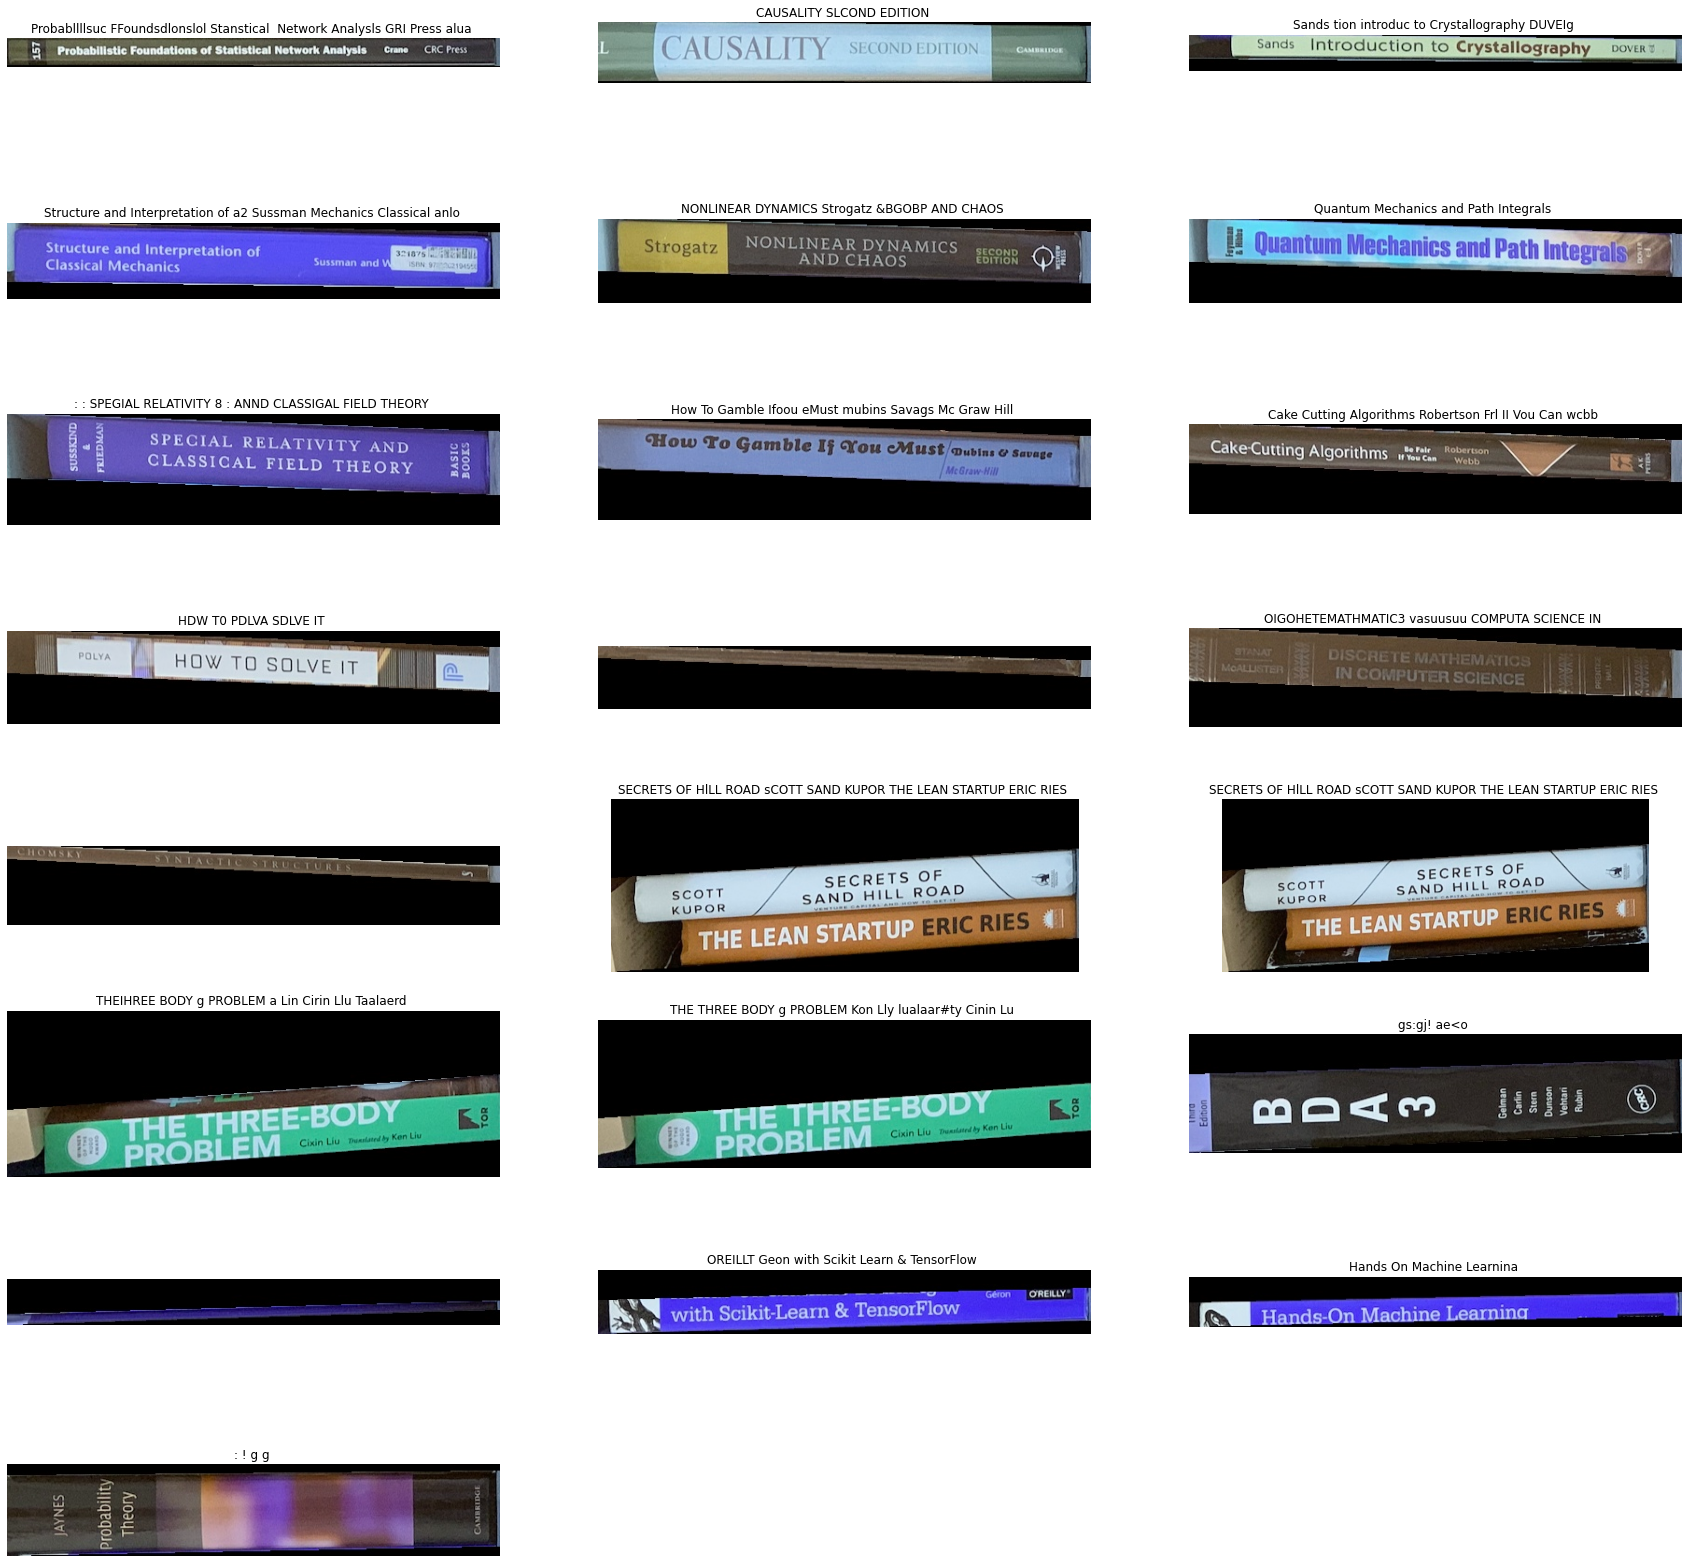

In [13]:
import os 
import cv2
import easyocr
import matplotlib.pyplot as plt

os.chdir('../filteredbooks_CV/')
reader = easyocr.Reader(['en'], gpu = False)

figure, axes = plt.subplots(nrows=8, ncols=3,figsize=(30,30))
col, row = 0,0
for index in range(24):
#     row = int(np.floor(index/3))
#     col = int(index%3)
    # read image
    image = cv2.imread(f'{row}_{col}.jpg')
    # pre-process
#     blur = cv2.GaussianBlur(image, (3,3), 0)
#     morph = cv2.morphologyEx(blur, cv2.MORPH_OPEN, np.ones((3,3),np.uint8)) 
#     gray = cv2.cvtColor(morph, cv2.COLOR_BGR2GRAY)
#     final = deskew(gray)
    
    # plot final
    axes[row, col].imshow(image, cmap="gray")
    axes[row, col].axis('off')
    plt.axis('off')

    # Easy OCR text extraction
    output = reader.readtext(f'{row}_{col}.jpg')
    data = ''
    for _, val in enumerate(output):
        data += val[1]+' '
    axes[row, col].set_title(data)
    
    # column/row logic for sub-plots
    if col == 2:
        col = 0
        row += 1
    else:
        col += 1
    
#delete the final two empty axes
figure.delaxes(axes.flatten()[-1])
figure.delaxes(axes.flatten()[-2])